![title](img/Recoanizing.png)
<p style="color:black;font-size:16px;"><strong>Apply Transfer learning using ResNet18</strong></p>
+ adapt a pretrained model from ImageNet with fine-tuning  
+ Dataset: CIFAR-10

### Import Libraries

In [42]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from skimage import io, transform
import torch.nn.functional as F
from torch.autograd import Variable

### Use GPU

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('GPU state:', device)

GPU state: cuda:0


### Data Preprocessing

In [7]:
#Convert pictures and apply data augenmentation to images 
transform = transforms.Compose(
    [
     transforms.Resize((224,224)), #Resize to 224*224
     transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Download training set and test set 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
#Data classes
classes = trainset.classes
print(classes)

#Get the number of images per class
class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


In [9]:
#Split the training set into training set, validation set, and testing set.
torch.manual_seed(43)
val_size = 10000
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print('Traning Dataset#: {:.4f}, Validation Dataset#: {:.4f}, Test Dataset#: {:4f}'.format(len(train_ds), len(val_ds), len(testset)))

trainLoader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2,pin_memory=True)
valLoader = DataLoader (val_ds, batch_size =64, num_workers=2, pin_memory=True)
testLoader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)

Traning Dataset#: 40000.0000, Validation Dataset#: 10000.0000, Test Dataset#: 10000.000000


images.shape: torch.Size([64, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


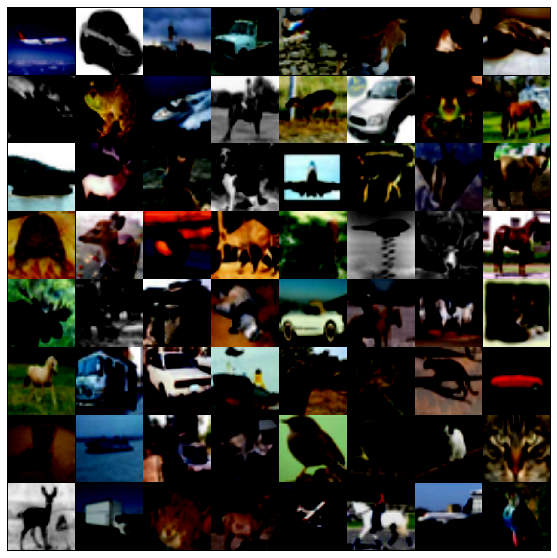

In [10]:
#Visualize some images in training set
for images, _ in trainLoader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(make_grid(images).permute((1, 2, 0)))
    break

### Define a CNN Model

>by adapting and finetung a ResNet-18 transfer learning framework

![ResNet18](img/ResNet18.png)

In [11]:
#Load ResNet model and parameters into the model
ResNet18 =  models.resnet18(pretrained = True)
ResNet18.to(device)
print(ResNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Change fc layer structure
inchannel = ResNet18.fc.in_features
# Add dropout and change the number of class
ResNet18.fc = nn.Linear(inchannel, 10)
#ResNet18.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(inchannel, 10))
print('Out_feature of Function Layer: {:.4f}'.format(ResNet18.fc.out_features))

#Freeze convolution weights
for param in ResNet18.parameters():
    param.requires_grad = False
#Unfreeze the parameters in last functional layer
for param in ResNet18.fc.parameters():
    param.requires_grad = True

Out_feature of Function Layer: 10.0000


In [13]:
#Switch device to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and ResNet18 model to GPU
ResNet18.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train the NN with Hyper-parameter Tuning
+ Optimizer 
+ Learning Rate Scheduling: iteratively reduce the learning rate after every 5 epochs.
+ Early stopping

In [14]:
#Define a loss function to check checks whether the model is moving in the correct direction and making progress
criterion = nn.CrossEntropyLoss() 

#Define an optimizer to improves the model to deliver accurate results.
#optimizer = optim.Adam(ResNet18.parameters(),lr=0.001, weight_decay=0.0001)  
optimizer = optim.SGD(ResNet18.parameters(), lr=0.001, momentum=0.9)

#Decays the learning rate by a factor of 0.1 every 5 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [15]:
#Train the model
epochs=15
epoch_no_improve=0
min_valid_loss = np.Inf
max_epoch_stop =5

train_running_loss_record = []
train_corrects_record = []
val_running_loss_record = []
val_corrects_record = []
PATH = './cifar_net.pth'

for epoch in range(epochs):
  
  ResNet18.train()
  train_running_loss = 0.0
  train_corrects = 0.0
  val_running_loss = 0.0
  val_corrects = 0.0
  
  for inputs, labels in trainLoader:
    inputs = inputs.to(device) 
    labels = labels.to(device)
    
    #Zero the parameter gradients
    optimizer.zero_grad()
    
    #Forward + backward + optimize
    outputs = ResNet18(inputs) 
    loss = criterion(outputs, labels)  
    loss.backward()
    optimizer.step()
    
    #Take the highest value of prediction.
    _, preds = torch.max(outputs, 1)
    train_running_loss += loss.item()
    
    #Calculate te accuracy by taking the sum of all the correct predictions in a batch.
    train_corrects += torch.sum(preds == labels.data) 

#Test with validataion dataset
  else:
    
    with torch.no_grad():
        ResNet18.eval()
        for val_inputs, val_labels in valLoader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = ResNet18(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_corrects += torch.sum(val_preds == val_labels.data)
    
        #Divide the total loss of one epoch with the enitre length of dataset to get the probability between 0 and 1
        train_epoch_loss = train_running_loss/len(trainLoader.dataset) # loss per epoch
        train_epoch_acc = train_corrects.float()/ len(trainLoader.dataset) # accuracy per epoch
        train_running_loss_record.append(train_epoch_loss) # appending for displaying 
        train_corrects_record.append(train_epoch_acc)
    
        val_epoch_loss = val_running_loss/len(valLoader.dataset)
        val_epoch_acc = val_corrects.float()/ len(valLoader.dataset)
        val_running_loss_record.append(val_epoch_loss)
        val_corrects_record.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('Training Loss: {:.4f}, Accuracy: {:.4f} '.format(train_epoch_loss, train_epoch_acc.item()))
        print('Validation Loss: {:.4f}, Accuracy: {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    
        if val_epoch_loss < min_valid_loss:
            #Save the model if validation loss decreases
            torch.save(ResNet18.state_dict, PATH)
            #Track improvement
            epoch_no_improve = 0
            min_valid_loss = val_epoch_loss
        else:
            epoch_no_improve += 1
            #Trigger early stopping
            if epoch_no_improve >= max_epoch_stop:
                print('Early stopping!')
                break 
                
    lr_scheduler.step()
    
    
print('Finished Training of ResNet18')

epoch : 1
Training Loss: 0.0169, Accuracy: 0.6662 
Validation Loss: 0.0122, Accuracy: 0.7502 
epoch : 2
Training Loss: 0.0116, Accuracy: 0.7572 
Validation Loss: 0.0108, Accuracy: 0.7715 
epoch : 3
Training Loss: 0.0108, Accuracy: 0.7681 
Validation Loss: 0.0106, Accuracy: 0.7773 
epoch : 4
Training Loss: 0.0104, Accuracy: 0.7737 
Validation Loss: 0.0101, Accuracy: 0.7802 
epoch : 5
Training Loss: 0.0101, Accuracy: 0.7794 
Validation Loss: 0.0100, Accuracy: 0.7808 
epoch : 6
Training Loss: 0.0099, Accuracy: 0.7850 
Validation Loss: 0.0099, Accuracy: 0.7850 
epoch : 7
Training Loss: 0.0099, Accuracy: 0.7843 
Validation Loss: 0.0099, Accuracy: 0.7842 
epoch : 8
Training Loss: 0.0099, Accuracy: 0.7847 
Validation Loss: 0.0098, Accuracy: 0.7864 
epoch : 9
Training Loss: 0.0099, Accuracy: 0.7837 
Validation Loss: 0.0099, Accuracy: 0.7839 
epoch : 10
Training Loss: 0.0098, Accuracy: 0.7859 
Validation Loss: 0.0098, Accuracy: 0.7900 
epoch : 11
Training Loss: 0.0098, Accuracy: 0.7864 
Validat

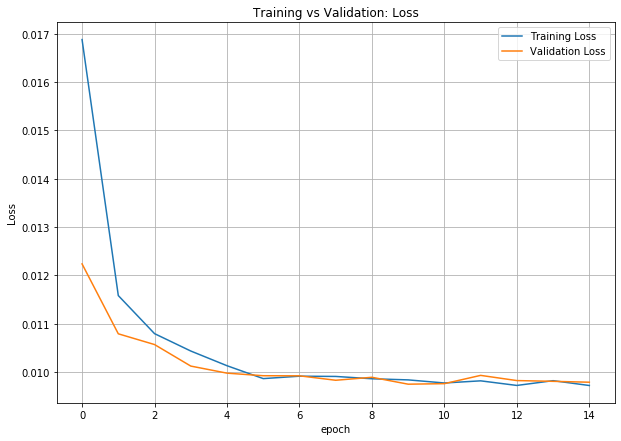

In [16]:
#Plot the losses 
plt.figure(figsize=(10, 7)) 
plt.plot(train_running_loss_record, label='Training Loss')
plt.plot(val_running_loss_record, label='Validation Loss')
plt.title('Training vs Validation: Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('loss.png') 
plt.show()

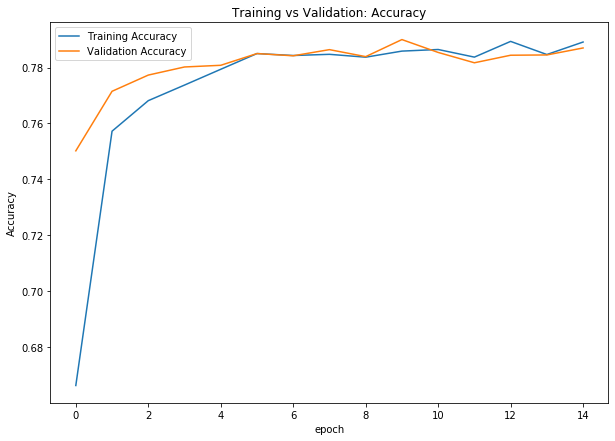

In [17]:
#Plot the accuracies
plt.figure(figsize=(10, 7)) 
plt.plot(train_corrects_record, label='Training Accuracy')
plt.plot(val_corrects_record, label='Validation Accuracy')
plt.title('Training vs Validation: Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

### Test the Trained Network

In [34]:
#Convert the images in order to plot them using plt
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [35]:
#Calcurate the accuracy of all test dataset
net = ResNet18.to(device)
correct = 0
total = 0
with torch.no_grad():
    net.eval()
    for int, data in enumerate(testLoader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
print('Accuracy of the network on the 10000 test inputs: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test inputs: 78 %


ship


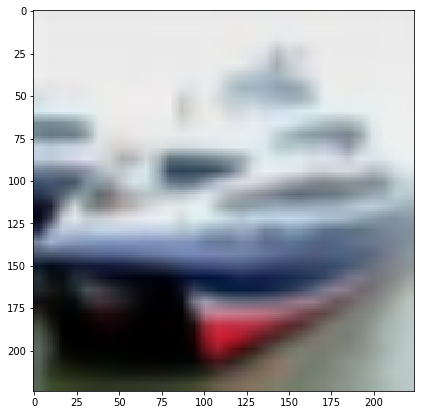

In [37]:
#Display an image from the test dataset
dataiter = iter(testLoader)
images, labels = dataiter.next()

fig = plt.figure(figsize =(10, 7))
plt.imshow(im_convert(images[1]))
print(str(classes[labels[1]]))

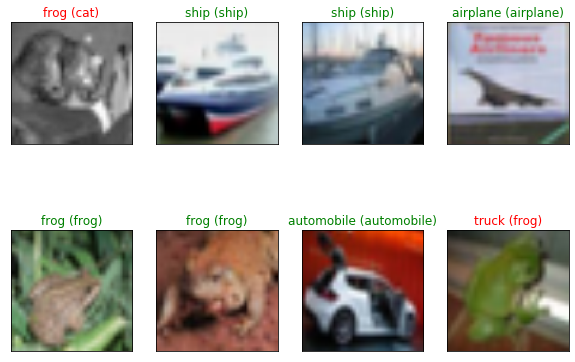

In [38]:
#Apply test dataset in trained network
#Check images with predicted names and actual names
dataiter = iter(testLoader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = net(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(10, 7))

for idx in np.arange(8):
  ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [39]:
#Check accuracy of each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    net.eval()
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        c = (preds == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 75 %
Accuracy of automobile : 87 %
Accuracy of  bird : 68 %
Accuracy of   cat : 69 %
Accuracy of  deer : 82 %
Accuracy of   dog : 73 %
Accuracy of  frog : 79 %
Accuracy of horse : 78 %
Accuracy of  ship : 86 %
Accuracy of truck : 86 %


### Let's try what would the model recognize my dog!

(1309, 828, 3)


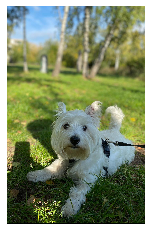

In [40]:
srcPath = 'Aiko.jpg'
src = io.imread(srcPath)
print(src.shape) 

plt.imshow(src) 
plt.axis('off')
plt.show()

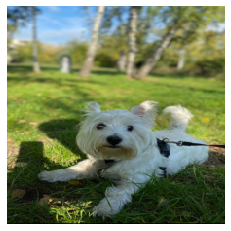

In [43]:
#Resize to 224x224 and convert to torch tensor
newImg = transform.resize(src, (224, 224))
plt.imshow(newImg)
plt.axis('off') 
plt.show()

imagebatch = newImg.reshape(-1,3,32,32)
image_tensor = torch.from_numpy(imagebatch).float()

In [44]:
net.eval()
output = net(image_tensor.to(device))
_, predicted = torch.max(output.data, 1)
pre = predicted.cpu().numpy()
print(classes[pre[0]])

frog


### Observations
+ The accuracy is around 80% on the validation data and 79% on the testing dataset. It can be concluded that the knowledge from ImageNet was able to successfully transfer to the CIFAR-10 dataset.
+ Training time was very slow. 
+ When training the model, using SGD with momentum has better accuracy than using Adam.
+ Increasing the number of epochs can improve the accuracy further.